### Import packages & initialization

In [1]:
from google.colab import drive
import sys
import torch
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import re
from skimage.io import imread
import logging
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/My Drive')

Mounted at /content/drive


In [2]:
!pip3 install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00


In [3]:
import functions
from functions import set_paths, get_pixels, add_gaussian_noise, delete_noisy_images, add_noisy_images, add_prefix_to_files
from functions import rename_images, rename_labels, UNet, get_args, train_model, ArgsBypass

In [4]:
drive_path =  'drive/MyDrive/Deep_Learning_Project_28/training_dataset/'
image_paths, label_paths, dir_img, dir_mask, dir_checkpoint = set_paths(drive_path=drive_path)

Total Observations:	 images 600 , labels 600


## Working Around

### Get Pixels

In [ ]:
image_path = drive_path + "data/001.tiff" # original dataset

pixels = get_pixels(image_path)

# Print the pixel values
print(min(pixels),torch.mean(pixels),max(pixels))

tensor(18465.) tensor(32907.8359) tensor(44477.)


### Visualization

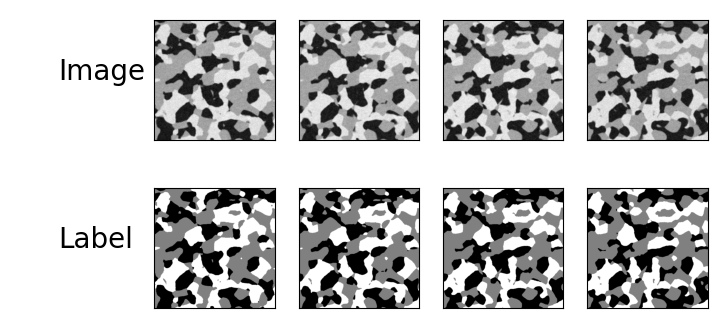

In [ ]:
# Display the first image and its segmentation
f, axarr = plt.subplots(2, 5, subplot_kw={'xticks': [], 'yticks': []}, figsize=(9, 4))

axarr[0,0].text(0.4, 0.5, 'Image', fontsize=20)
axarr[0,0].axis('off')
axarr[0,0].set_clip_on(False)


axarr[1,0].text(0.4, 0.5, 'Label', fontsize=20)
axarr[1,0].axis('off')
axarr[1,0].set_clip_on(False)

for i in range(4):
  image = imread(image_paths[i*4], as_gray=True)
  axarr[0,i+1].imshow(image, cmap='gray')

  label = imread(label_paths[i*4], as_gray=True)
  axarr[1,i+1].imshow(label, cmap='gray')

plt.show()

### Example of a Noisy Image

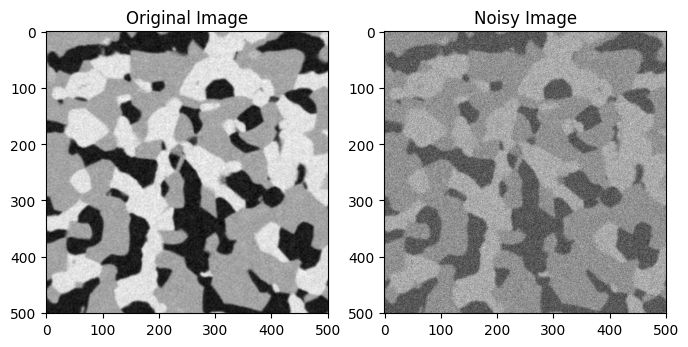

In [10]:
std = 5000

#image_path = drive_path + "data/SOCprist0081.tiff"
image_path = drive_path + "data/081.tiff"
original_image = Image.open(image_path)

# Add Gaussian noise
noisy_image = add_gaussian_noise(original_image, mean=0, std=std)

# Display original and noisy images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title('Noisy Image')


# Save the figure
plt.savefig(drive_path+'original_and_noisy_images_compare.png')

plt.show()

# Convert the image to a NumPy array
np_array = np.array(noisy_image, dtype=np.float32)

# Convert the NumPy array to a PyTorch tensor
tensor_image = torch.from_numpy(np_array)

# Flatten the tensor to get the pixel values
flattened_pixels = tensor_image.view(-1)

In [9]:
drive_path

'drive/MyDrive/Deep_Learning_Project_28/training_dataset/'

### Class encoding

From the label images of the previous cell we see that the classes are encoded as grayscale images of three shades.

This means there is one color channel, no third dimension.

In [ ]:
label = imread(label_paths[0], as_gray=True)
print(label.shape)

(501, 501)


 And three pixel values (0, 128, 255).

In [ ]:
unique, counts = np.unique(label, return_counts=True)
print(np.asarray((unique, counts)).T)

[[    0 79317]
 [  128 89810]
 [  255 81874]]


## Noisy Images

### Delete Noisy Images

In [ ]:
# output_folder_path = drive_path + "data/"
# delete_noisy_images(output_folder_path)
# print(f"Noisy images in {output_folder_path} deleted.")


# output_folder_path = drive_path + "labels/"
# delete_noisy_images(output_folder_path)
# print(f"Noisy images in {output_folder_path} deleted.")

Noisy images in drive/MyDrive/Deep_Learning_Project_28/training_dataset/data/ deleted.
Noisy images in drive/MyDrive/Deep_Learning_Project_28/training_dataset/labels/ deleted.


### Add Prefix
(This is used if one wants to get the original names of the labels)

In [ ]:
# prefix = "slice__"

# add_prefix_to_files(drive_path , prefix)

### Add Noisy Images

In [ ]:
# add_noisy_images(drive_path = drive_path,n=100,std=5000)

Noisy images saved to drive/MyDrive/Deep_Learning_Project_28/training_dataset/data/


## Preprocessing

### Rename images

In [ ]:
# rename_images(image_paths = image_paths,drive_path = drive_path)
# rename_labels(label_paths = label_paths,drive_path =drive_path)

In [ ]:
image_paths, label_paths, dir_img, dir_mask, dir_checkpoint = set_paths(drive_path=drive_path)

Total Observations:	 images 600 , labels 600


## Train the model

In [ ]:
args = ArgsBypass()

logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.info(f'Using device {device}')

# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
# model = UNet(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)
model = UNet(n_channels=1, n_classes=args.classes, bilinear=args.bilinear)
model = model.to(memory_format=torch.channels_last)

logging.info(f'Network:\n'
              f'\t{model.n_channels} input channels\n'
              f'\t{model.n_classes} output channels (classes)\n'
              f'\t{"Bilinear" if model.bilinear else "Transposed conv"} upscaling')

if args.load:
    state_dict = torch.load(args.load, map_location=device)
    del state_dict['mask_values']
    model.load_state_dict(state_dict)
    logging.info(f'Model loaded from {args.load}')

model.to(device=device)
try:
    train_model(
        model=model,
        dir_img=dir_img,
        dir_mask=dir_mask,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp,
        val_original_percent=0.5,
        num_train_records = 50,
        split_type = 'random_split'
    )
except torch.cuda.OutOfMemoryError:
    logging.error('Detected OutOfMemoryError! '
                  'Enabling checkpointing to reduce memory usage, but this slows down training. '
                  'Consider enabling AMP (--amp) for fast and memory efficient training')
    torch.cuda.empty_cache()
    model.use_checkpointing()
    train_model(
        model=model,
        dir_img=dir_img,
        dir_mask=dir_mask,
        epochs=args.epochs,
        batch_size=args.batch_size,
        learning_rate=args.lr,
        device=device,
        img_scale=args.scale,
        val_percent=args.val / 100,
        amp=args.amp,
        val_original_percent=0.5,
        num_train_records = 50,
        split_type = 'random_split'
    )

100%|██████████| 600/600 [00:22<00:00, 26.46it/s]


random_split
540 60


wandb: Currently logged in as: anony-mouse-482083588391527406. Use `wandb login --relogin` to force relogin


Epoch 1/5:   0%|          | 1/540 [00:48<7:18:36, 48.82s/img, loss (batch)=1.98]